In [31]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os 

## A basic dataset class for PUG: ImageNet

In [8]:
PUG_IMAGENET_PATH = ""

class UnrealDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.df.astype(str)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getIndicesByFactors__(self, world_name="City", character_label="GoldFish", character_scale=1.0, character_texture='Default', camera_yaw=0):
        indices = dataset.df[#(dataset.df['world_name'] == world_name)
                            (dataset.df['character_label'] == character_label)]                            
        return indices.index.values
    
    def __getitem__(self, index):
        filename = self.df['filename'][index]
        label = self.df['character_label'][index]
        image = Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, self.df['world_name'][index], self.df['character_label'][index]

dataset = UnrealDataset(csv_path=PUG_IMAGENET_PATH+"/labels_pug_imagenet.csv", images_folder=PUG_IMAGENET_PATH)

## Samples from the PUG: ImageNet dataset

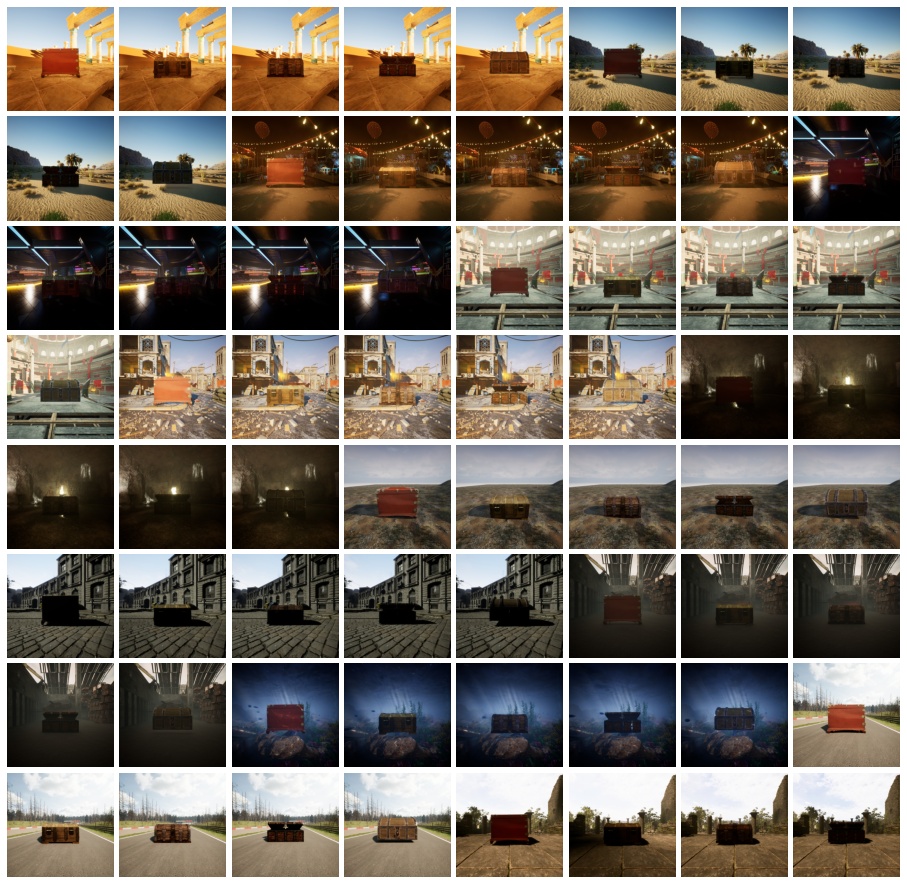

In [47]:
f, axarr = plt.subplots(8,8, figsize=(16,16))
list_world_names = dataset.df["world_name"].unique().tolist()
list_characters_names = dataset.df["character_label"].unique().tolist()
i = 0
j = 0
indexes = dataset.__getIndicesByFactors__(character_label='Chest')
for k in range(64):
    data = dataset.__getitem__(indexes[k])
    img = data[0]
    axarr[j,i%8].axis('off')
    axarr[j,i%8].imshow(img, aspect="auto")
    i = i + 1
    j = int(i / 8)
f.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

# How to run evaluations on PUG: ImageNet

The step below is important since it allows us to convert the 151 Pug:ImageNet labels to the correct label in the real ImageNet dataset (which contains 1000 classes).

In [44]:
import json

# This is the file that map the PUG: ImageNet class indexes (from 0 to 151) to the real ImageNet classes (up to 1000)
with open('class_to_imagenet_idx.json') as f:
    labels = json.load(f)
labels = dict(sorted(labels.items()))
# Then we create a disctionary that map an imagenet class to the PUG:ImageNet class
inversed_dict = {}
counter = 0
for k,v in labels.items():
    for val in v:
        inversed_dict[int(val)] = counter
    counter = counter + 1
print(inversed_dict)

{49: 0, 403: 1, 404: 2, 407: 3, 944: 4, 414: 5, 931: 6, 954: 7, 427: 8, 429: 9, 430: 10, 435: 11, 294: 12, 295: 12, 296: 12, 297: 12, 945: 13, 447: 14, 448: 15, 453: 16, 821: 17, 839: 17, 937: 18, 465: 19, 965: 20, 942: 21, 444: 22, 671: 22, 936: 23, 473: 24, 470: 25, 472: 26, 479: 27, 476: 28, 478: 29, 282: 30, 283: 30, 284: 30, 285: 30, 487: 31, 491: 32, 933: 33, 492: 34, 8: 35, 504: 36, 508: 37, 511: 38, 515: 39, 519: 40, 526: 41, 528: 42, 531: 43, 532: 44, 534: 45, 541: 46, 545: 47, 385: 48, 386: 48, 550: 49, 277: 50, 278: 50, 279: 50, 280: 50, 930: 51, 30: 52, 31: 52, 32: 52, 570: 53, 1: 54, 2: 55, 589: 56, 593: 57, 596: 58, 958: 59, 928: 60, 607: 61, 608: 62, 609: 63, 107: 64, 613: 65, 104: 66, 48: 67, 620: 68, 621: 69, 626: 70, 547: 71, 820: 71, 633: 72, 637: 73, 640: 74, 643: 75, 691: 75, 796: 75, 650: 76, 651: 77, 652: 78, 656: 79, 662: 80, 670: 81, 673: 82, 947: 83, 682: 84, 698: 85, 703: 86, 707: 87, 145: 88, 711: 89, 579: 90, 953: 91, 963: 92, 732: 93, 957: 94, 736: 95, 740

### Creating a dataloader

Then we create a dataloader using the PUG: ImageNet worlds subsets (which evaluate the performances accross backgrounds). You can switch the subset from one of the following values:
Worlds, Camera_Pitch, Camera_Yaw,  Camera_Roll, Object_Pitch, Object_Yaw, Object_Roll, Object_Scale, Object_Texture, Scene_Light

In [19]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

# Set data transformations
tr_normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
transform_val = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    tr_normalize,
])

# Create dataloaders
val_dataset_world = datasets.ImageFolder(PUG_IMAGENET_PATH+"Worlds/", transform=transform_val)
dataloader = DataLoader(val_dataset_world, batch_size=64, shuffle=False, num_workers=4, drop_last=False)

### Using a pretrained model

In [20]:
import torchvision
# We use a pretrained resnet50 in this example
model = torchvision.models.resnet50(pretrained=True)
model.eval()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Run the evaluation

In [29]:
list_corrects = []
nb_corrects = 0.
for k, (images, labels) in enumerate(dataloader):
    images = images.cuda()
    labels = labels.cuda()
    with torch.no_grad(), torch.cuda.amp.autocast():
        output = model(images).softmax(dim=-1)
        pred = torch.argmax(output, dim=1)
        # This is used to convert the index predicted by the pretraned model into one of the 151 labels contained in PUG: ImageNet
        for p in range(pred.size(0)):
            if pred[p].item() in inversed_dict.keys():
                pred[p] = inversed_dict[pred[p].item()]
            else:
                pred[p] = 999 # We put random value if the predicted class is not in the 151 labels we are using
        nb_corrects += sum((pred == labels).float())
print("Accuracy: ", (nb_corrects/len(val_dataset_world))*100.)

Acc:  tensor(27.8617, device='cuda:0')
